# Задание 1 (6 баллов)

В данном задании мы будем работать со [списком 250 лучших фильмов IMDb](https://www.imdb.com/chart/top/?ref_=nv_mp_mv250)

1. Выведите топ-4 *фильма* **по количеству оценок пользователей** и **количество этих оценок** (1 балл)
2. Выведите топ-4 лучших *года* (**по среднему рейтингу фильмов в этом году**) и **средний рейтинг** (1 балл)
3. Постройте отсортированный **barplot**, где показано **количество фильмов** из списка **для каждого режисёра** (только для режиссёров с более чем 2 фильмами в списке) (1 балл)
4. Выведите топ-4 самых популярных *режиссёра* (**по общему числу людей оценивших их фильмы**) (2 балла)
5. Сохраните данные по всем 250 фильмам в виде таблицы с колонками (name, rank, year, rating, n_reviews, director) в любом формате (2 балла)

Использовать можно что-угодно, но полученные данные должны быть +- актуальными на момент сдачи задания

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import io
from dotenv import load_dotenv

For convinience, firstly I have created DataFrame with data for all 250 Top IMDb films.

In [2]:
response = requests.get("https://www.imdb.com/chart/top/?ref_=nv_mp_mv250")
soup = BeautifulSoup(response.content, "lxml")

films_dict = {}
# tags list with title name, year, and director
rating_list = soup.find_all("td", attrs={"class": "titleColumn"})

# extracting title names
titles = [title.find('a').get_text() for title in rating_list]
films_dict.update({"name": titles})

# extracting ranks
ranks = [int(i.a.previous_element.strip()[:-1]) for i in rating_list]
films_dict.update({"rank": ranks})

# extracting years
years_pattern = re.compile(r'\d{4}')
years = [re.search(years_pattern, title.find('span').get_text())[0] for title in rating_list]
films_dict.update({"year": years})

# extracting ratings and n_reviews
rate_reviews_list = soup.find_all("td", attrs={"class": "ratingColumn imdbRating"})
rate_reviews_pattern = re.compile(r'(\d+([,\.]{1}\d+)+)')
films_dict.update({"rating": [], "n_reviews": []})
for i in rate_reviews_list:
    (mark, _), (n_votes, _) = re.findall(rate_reviews_pattern, i.strong.attrs["title"])
    films_dict["rating"].append(float(mark))
    films_dict["n_reviews"].append(int(n_votes.replace(",", "")))

# extracting directors    
directors = [direc.a.attrs["title"].split(" (")[0] for direc in rating_list]
films_dict.update({"directors": directors})
films_df = pd.DataFrame(films_dict)

In [3]:
# Task1
top_reviewed = films_df[["name", "n_reviews"]].sort_values(by="n_reviews", ascending=False).head(4)
top_reviewed

,name,n_reviews
0,Побег из Шоушенка,2720876
2,Темный рыцарь,2693691
13,Начало,2390584
11,Бойцовский клуб,2164308


In [4]:
# Task2
top_years = films_df.groupby("year")["rating"].mean().sort_values(ascending=False).head(4)
top_years

year
1972    9.20
1994    8.76
1974    8.55
1991    8.55
Name: rating, dtype: float64

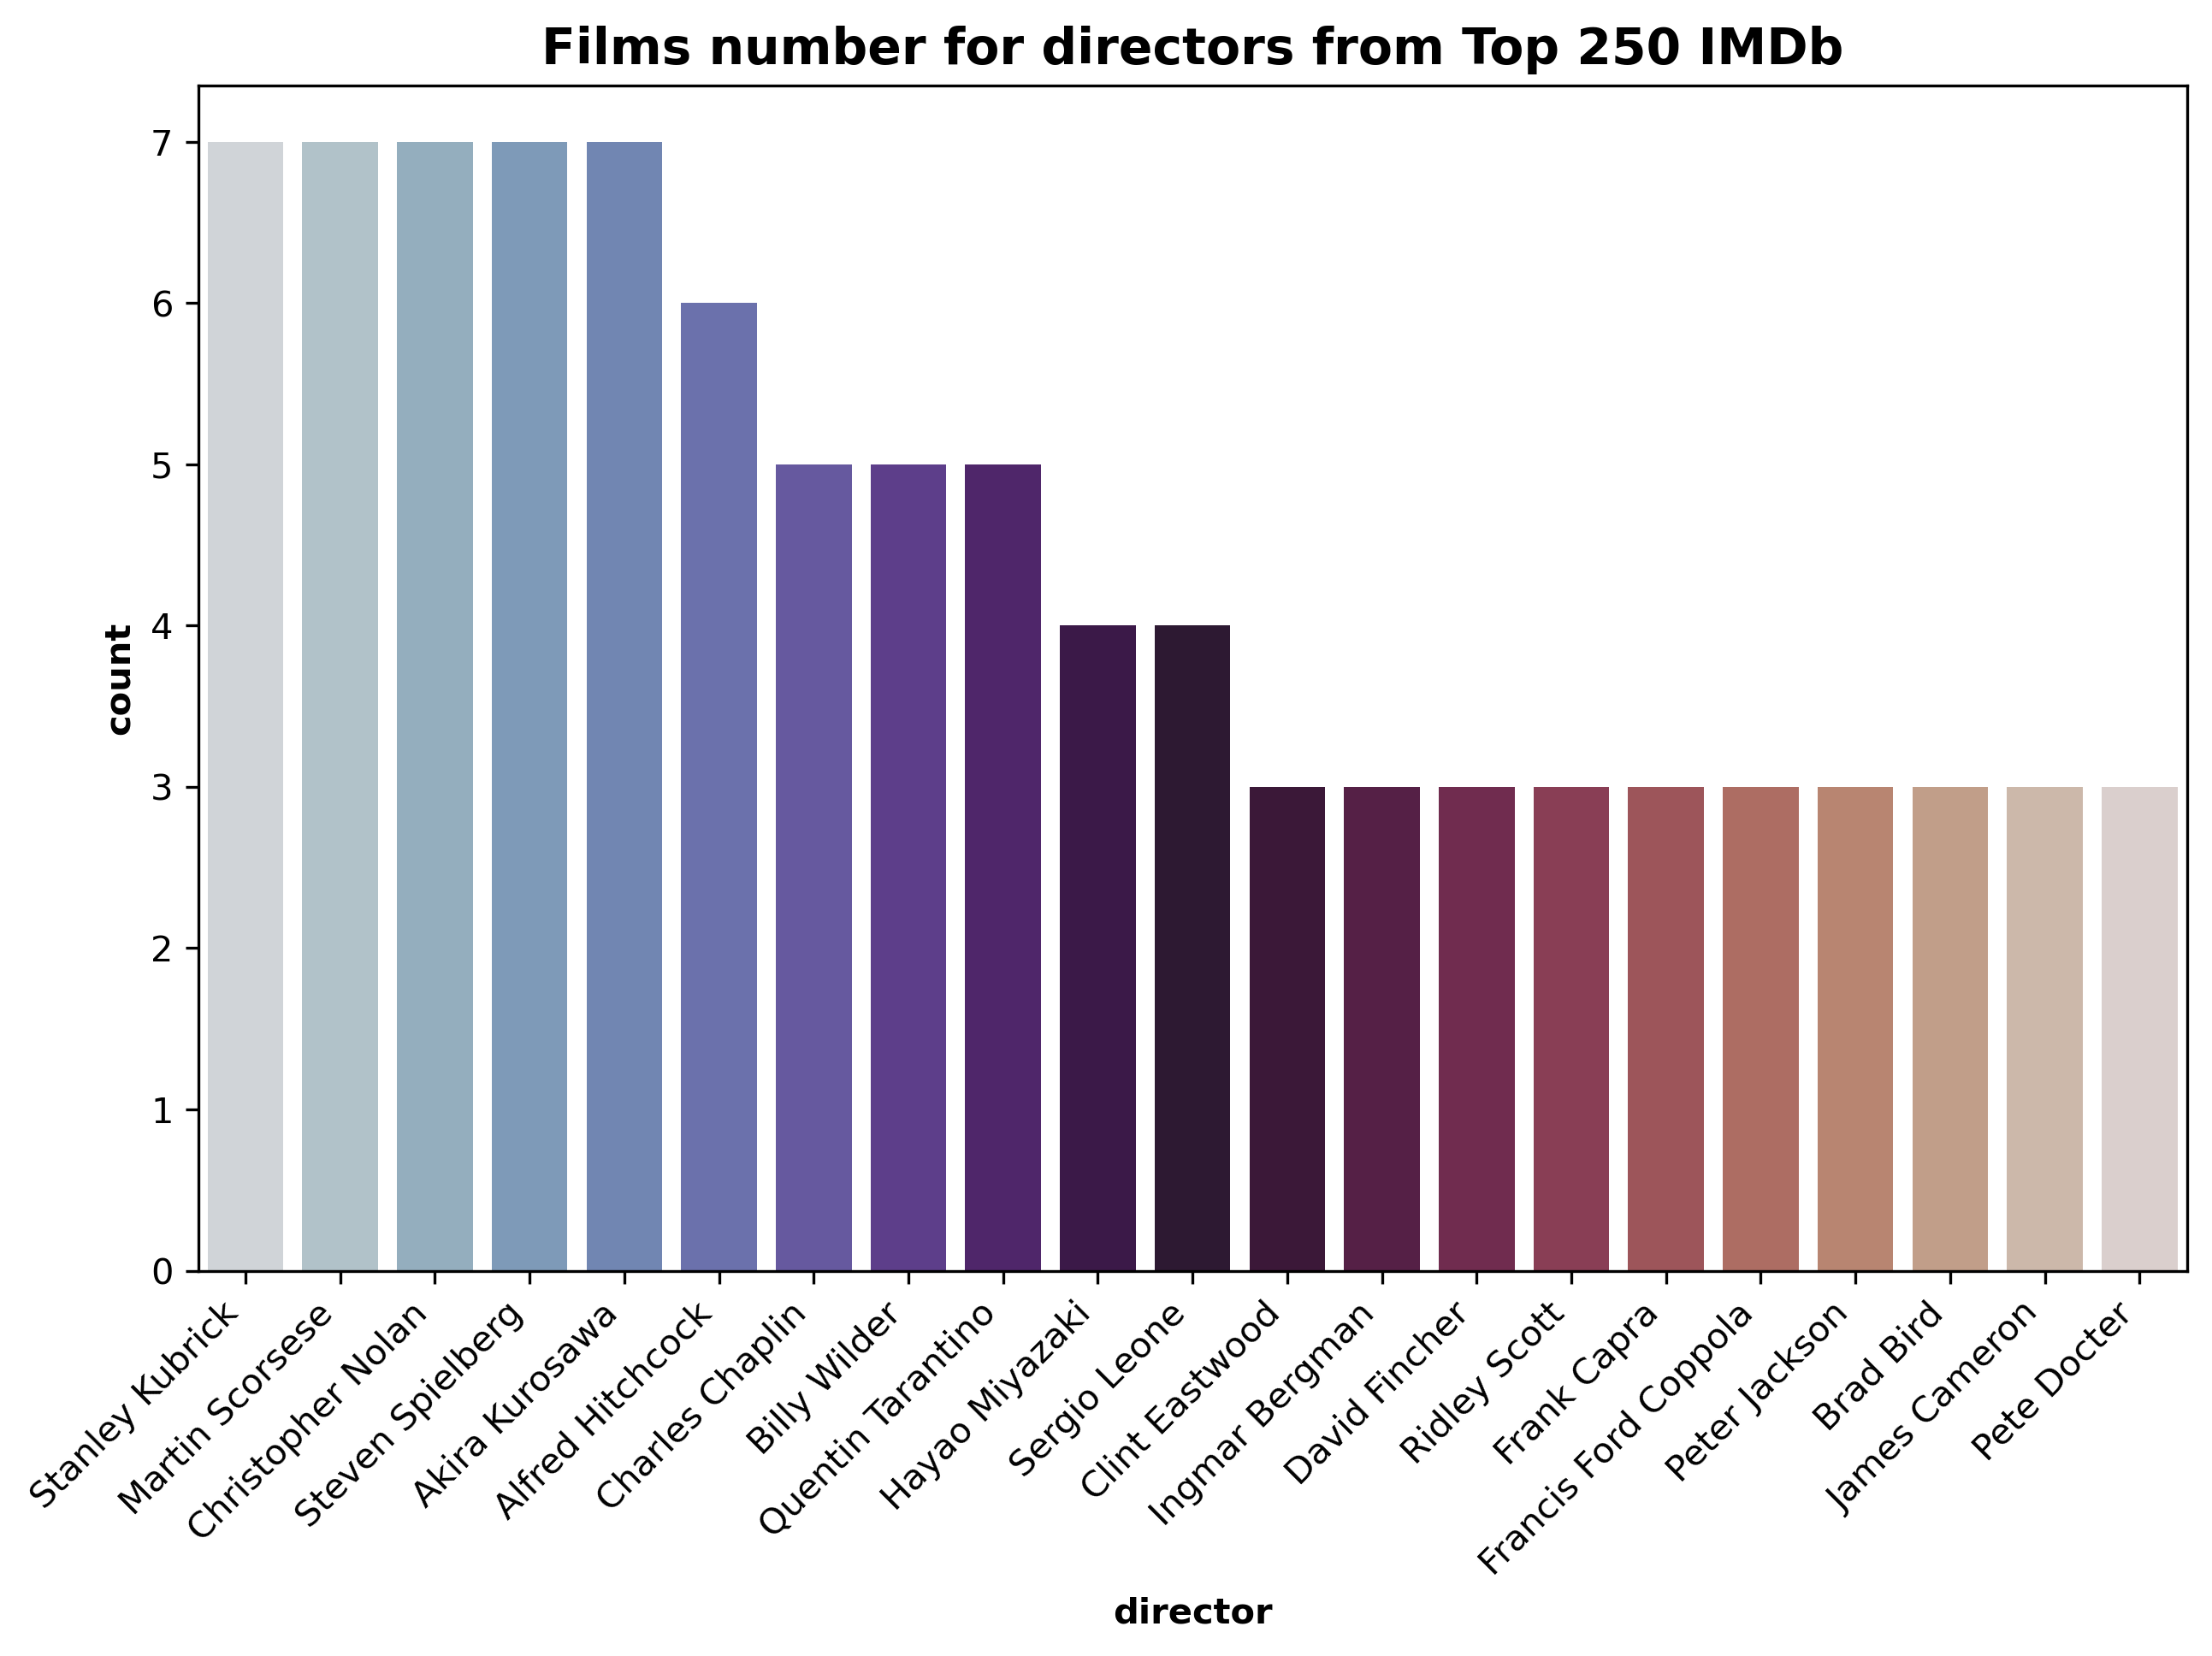

In [5]:
# Task3
directors_count  = films_df["directors"].value_counts()
directors_count = directors_count[directors_count > 2]

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
sns.barplot(x=directors_count.index, y=directors_count.values, palette="twilight", ax=ax)
ax.set_title("Films number for directors from Top 250 IMDb", fontsize=14, fontweight='bold')
ax.set_xlabel("director", fontweight='bold')
ax.set_xticklabels(directors_count.index, rotation=45, ha="right")
ax.set_ylabel("count", fontweight='bold');

In [6]:
# Task4
films_df.groupby("directors")["n_reviews"].sum().sort_values(ascending=False).head(4)

directors
Christopher Nolan    12792756
Quentin Tarantino     7315831
Steven Spielberg      7162616
Martin Scorsese       7057364
Name: n_reviews, dtype: int64

In [7]:
# Task5
print(films_df.shape)
films_df.head()

(250, 6)


,name,rank,year,rating,n_reviews,directors
0,Побег из Шоушенка,1,1994,9.2,2720876,Frank Darabont
1,Крёстный отец,2,1972,9.2,1890804,Francis Ford Coppola
2,Темный рыцарь,3,2008,9.0,2693691,Christopher Nolan
3,Крёстный отец 2,4,1974,9.0,1290038,Francis Ford Coppola
4,12 рaзгневанных мужчин,5,1957,9.0,804294,Sidney Lumet


# Задание 2 (10 баллов)

Напишите декоратор `telegram_logger`, который будет логировать запуски декорируемых функций и отправлять сообщения в телеграм.


Вся информация про API телеграм ботов есть в официальной документации, начать изучение можно с [этой страницы](https://core.telegram.org/bots#how-do-bots-work) (разделы "How Do Bots Work?" и "How Do I Create a Bot?"), далее идите в [API reference](https://core.telegram.org/bots/api)

**Основной функционал:**
1. Декоратор должен принимать **один обязательный аргумент** &mdash; ваш **CHAT_ID** в телеграме. Как узнать свой **CHAT_ID** можно найти в интернете
2. В сообщении об успешно завершённой функции должны быть указаны её **имя** и **время выполнения**
3. В сообщении о функции, завершившейся с исключением, должно быть указано **имя функции**, **тип** и **текст ошибки**
4. Ключевые элементы сообщения должны быть выделены **как код** (см. скриншот), форматирование остальных элементов по вашему желанию
5. Время выполнения менее 1 дня отображается как `HH:MM:SS.μμμμμμ`, время выполнения более 1 дня как `DDD days, HH:MM:SS`. Писать форматирование самим не нужно, всё уже где-то сделано за вас

**Дополнительный функционал:**
1. К сообщению также должен быть прикреплён **файл**, содержащий всё, что декорируемая функция записывала в `stdout` и `stderr` во время выполнения. Имя файла это имя декорируемой функции с расширением `.log` (**+3 дополнительных балла**)
2. Реализовать предыдущий пункт, не создавая файлов на диске (**+2 дополнительных балла**)
3. Если функция ничего не печатает в `stdout` и `stderr` &mdash; отправлять файл не нужно

**Важные примечания:**
1. Ни в коем случае не храните свой API токен в коде и не загружайте его ни в каком виде свой в репозиторий. Сохраните его в **переменной окружения** `TG_API_TOKEN`, тогда его можно будет получить из кода при помощи `os.getenv("TG_API_TOKEN")`. Ручное создание переменных окружения может быть не очень удобным, поэтому можете воспользоваться функцией `load_dotenv` из модуля [dotenv](https://pypi.org/project/python-dotenv/). В доке всё написано, но если коротко, то нужно создать файл `.env` в текущей папке и записать туда `TG_API_TOKEN=<your_token>`, тогда вызов `load_dotenv()` создаст переменные окружения из всех переменных в файле. Это довольно часто используемый способ хранения ключей и прочих приватных данных
2. Функцию `long_lasting_function` из примера по понятным причинам запускать не нужно. Достаточно просто убедится, что большие временные интервалы правильно форматируются при отправке сообщения (как в примерах)
3. Допустима реализация логирования, когда логгер полностью перехватывает запись в `stdout` и `stderr` (то есть при выполнении функций печать происходит **только** в файл)
4. В реальной жизни вам не нужно использовать Telegram API при помощи ручных запросов, вместо этого стоит всегда использовать специальные библиотеки Python, реализующие Telegram API, они более высокоуровневые и удобные. В данном задании мы просто учимся работать с API при помощи написания велосипеда.
5. Обязательно прочтите часть конспекта лекции про API перед выполнением задания, так как мы довольно поверхностно затронули это на лекции

**Рекомендуемые к использованию модули:**
1. os
2. sys
3. io
4. datetime
5. requests
6. dotenv

**Запрещённые модули**:
1. Любые библиотеки, реализующие Telegram API в Python (*python-telegram-bot, Telethon, pyrogram, aiogram, telebot* и так далле...)
2. Библиотеки, занимающиеся "перехватыванием" данных из `stdout` и `stderr` (*pytest-capturelog, contextlib, logging*  и так далле...)



Результат запуска кода ниже должен быть примерно такой:

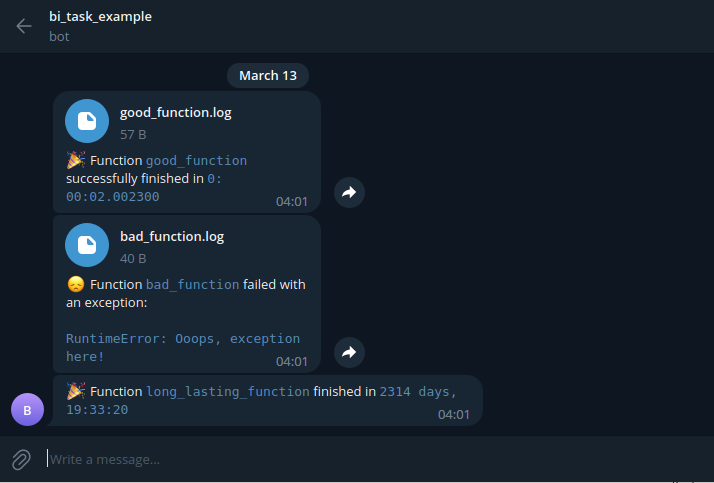

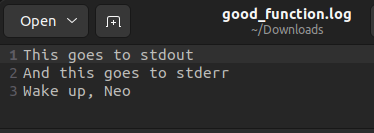

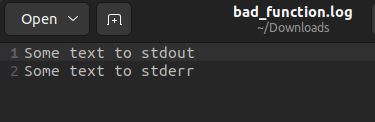

In [8]:
load_dotenv()
TG_API_TOKEN = os.getenv("TG_API_TOKEN")
chat_id = os.getenv("TG_CHAT_ID")

def telegram_logger(chat_id):
    '''A decorator for calculating function exacution time, 
    creating .log file, and sending it to telegram bot
    
    Parameters:
        chat_id (str): chat id for sending messages by bot
    '''
    
    
    def wrapper(func):
        def inner_func(*args, **kwargs):
            url = f'https://api.telegram.org/bot{TG_API_TOKEN}/'
            text_buffer = io.StringIO()
            sys.stdout = sys.stderr = text_buffer
            
            try:
                start = time.time()
                if func.__name__ == 'long_lasting_function':
                    longtime = 200000000
                    result = None
                else:
                    result = func(*args, **kwargs)
                    longtime = 0
                run_time = time.time() - start + longtime
                
                if run_time > 24*60*60:
                    run_time = round(run_time)
                run_time = datetime.timedelta(seconds=run_time)
                
                text = f'Function `{func.__name__}` is done.\nRuntime: `{run_time}`'
            except Exception as error:
                text = f'Function `{func.__name__}` failed.\n`{type(error).__name__}: {error}`'
            sys.stdout, sys.stderr = sys.__stdout__, sys.__stderr__
            data = {'chat_id': chat_id, 'text':text, 'caption':text, 'parse_mode':'Markdown'}
            file = text_buffer.getvalue()
            if file:
                requests.post(url + 'sendDocument', data=data, files={'document':(f'{func.__name__}.log',file)})
            else:
                requests.post(url + 'sendMessage', data=data)
            return result
        return inner_func
    return wrapper


@telegram_logger(chat_id)
def good_function():
    print("This goes to stdout")
    print("And this goes to stderr", file=sys.stderr)
    time.sleep(2)
    print("Wake up, Neo")

@telegram_logger(chat_id)
def bad_function():
    print("Some text to stdout")
    time.sleep(2)
    print("Some text to stderr", file=sys.stderr)
    raise RuntimeError("Ooops, exception here!")
    print("This text follows exception and should not appear in logs")
    
@telegram_logger(chat_id)
def long_lasting_function():
    time.sleep(200000000)


good_function()

try:
    bad_function()
except Exception:
    pass

long_lasting_function()

# Задание 3

В данном задании от вас потребуется сделать Python API для какого-либо сервиса

В задании предложено два варианта: простой и сложный, **выберите только один** из них.

Можно использовать только **модули стандартной библиотеки** и **requests**. Любые другие модули можно по согласованию с преподавателем.

❗❗❗ В **данном задании** требуется оформить код в виде отдельного модуля (как будто вы пишете свою библиотеку). Код в ноутбуке проверяться не будет ❗❗❗

## Вариант 1 (простой, 10 баллов)

В данном задании вам потребуется сделать Python API для сервиса http://hollywood.mit.edu/GENSCAN.html

Он способен находить и вырезать интроны в переданной нуклеотидной последовательности. Делает он это не очень хорошо, но это лучше, чем ничего. К тому же у него действительно нет публичного API.

Реализуйте следующую функцию:
`run_genscan(sequence=None, sequence_file=None, organism="Vertebrate", exon_cutoff=1.00, sequence_name="")` &mdash; выполняет запрос аналогичный заполнению формы на сайте. Принимает на вход все параметры, которые можно указать на сайте (кроме Print options). `sequence` &mdash; последовательность в виде строки или любого удобного вам типа данных, `sequence_file` &mdash; путь к файлу с последовательностью, который может быть загружен и использован вместо `sequence`. Функция должна будет возвращать объект типа `GenscanOutput`. Про него дальше.

Реализуйте **датакласс** `GenscanOutput`, у него должны быть следующие поля:
+ `status` &mdash; статус запроса
+ `cds_list` &mdash; список предсказанных белковых последовательностей с учётом сплайсинга (в самом конце результатов с сайта)
+ `intron_list` &mdash; список найденных интронов. Один интрон можно представить любым типом данных, но он должен хранить информацию о его порядковом номере, его начале и конце. Информацию о интронах можно получить из первой таблицы в результатах на сайте.
+ `exon_list` &mdash; всё аналогично интронам, но только с экзонами.

По желанию можно добавить любые данные, которые вы найдёте в результатах

In [ ]:
# Не пиши код здесь, сделай отдельный модуль

## Вариант 2 (очень сложный, 20 дополнительных баллов)

В этом варианте от вас потребуется сделать Python API для BLAST, а именно для конкретной вариации **tblastn** https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=tblastn&PAGE_TYPE=BlastSearch&LINK_LOC=blasthome

Хоть у BLAST и есть десктопное приложение, всё-таки есть одна область, где API может быть полезен. Если мы хотим искать последовательность в полногеномных сборках (WGS), а не в базах данных отдельных генов, у нас могут возникнуть проблемы. Так как если мы хотим пробластить нашу последовательность против большого количества геномов нам пришлось бы или вручную отправлять запросы на сайте, или скачивать все геномы и делать поиск локально. И тот и другой способы не очень удобны, поэтому круто было бы иметь способ сделать автоматический запрос, не заходя в браузер.

Необходимо написать функцию для запроса, которая будет принимать 3 обязательных аргумента: **белковая последовательность**, которую мы бластим, **базу данных** (в этом задании нас интересует только WGS, но по желанию можете добавить какую-нибудь ещё), **таксон**, у которого мы ищем последовательность, чаще всего &mdash; конкретный вид. По=желанию можете добавить также любые другие аргументы, соответствующие различным настройкам поиска на сайте. 

Функция дожна возвращать список объектов типа `Alignment`, у него должны быть следующие атрибуты (всё согласно результатам в браузере, удобно посмотреть на рисунке ниже), можно добавить что-нибудь своё:

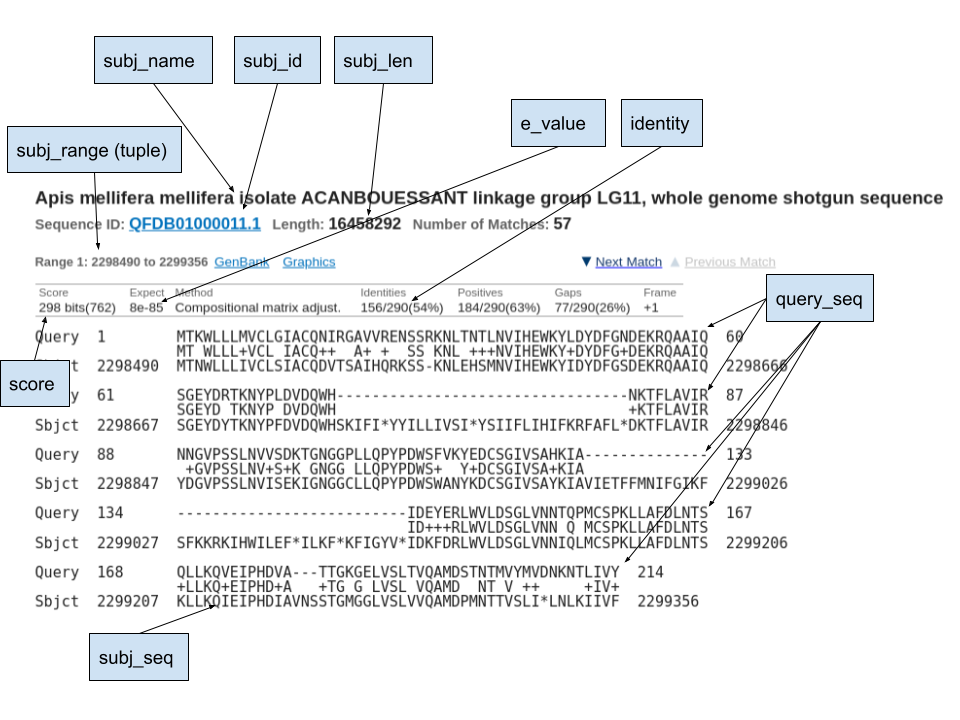


Самое сложное в задании - правильно сделать запрос. Для этого нужно очень глубоко погрузиться в то, что происходит при отправке запроса при помощи инструмента для разработчиков. Ещё одна проблема заключается в том, что BLAST не отдаёт результаты сразу, какое-то время ваш запрос обрабатывается, при этом изначальный запрос не перекидывает вас на страницу с результатами. Задание не такое простое как кажется из описания!